<a target="_blank" href="https://colab.research.google.com/github/LBL-EESA/fastkde/blob/main/testing/readme_test.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This notebook demonstrates the example provided in the fastKDE `README.md`.

# fastKDE

## Software Overview

fastKDE calculates a kernel density estimate of arbitrarily dimensioned
data; it does so rapidly and robustly using recently developed KDE
techniques. It does so with statistical skill that is as good as
state-of-the-science 'R' KDE packages, and it does so 10,000 times
faster for bivariate data (even better improvements for higher
dimensionality).

*Please cite the following papers when using this method:*

  `O’Brien, T. A., Kashinath, K., Cavanaugh, N. R., Collins, W. D. & O’Brien, J. P. A fast and objective multidimensional kernel density estimation method: fastKDE. Comput. Stat. Data Anal. 101, 148–160 (2016). <http://dx.doi.org/10.1016/j.csda.2016.02.014>`__

  `O’Brien, T. A., Collins, W. D., Rauscher, S. A. & Ringler, T. D. Reducing the computational cost of the ECF using a nuFFT: A fast and objective probability density estimation method. Comput. Stat. Data Anal. 79, 222–234 (2014). <http://dx.doi.org/10.1016/j.csda.2014.06.002>`__

### Example usage:


In [1]:
""" Install fastkde if not already installed """""
try:
    import fastkde
except:
    # Install a pip package in the current Jupyter kernel (this works in google colab but might not work in other environments with multiple python versions installed)
    !pip install fastkde
    import fastkde

## Basic example

The following test shows fastKDE working on samples drawn independently from $\mathcal{N}(0.1,50)$ and $\mathcal{N}(-300,0.01)$.

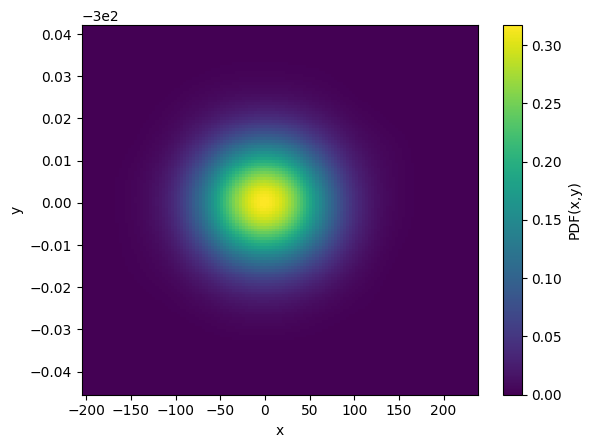

In [2]:
""" Demonstrate the first README example. """
import numpy as np
import fastkde
import matplotlib.pyplot as plt

#Generate two random variables dataset (representing 100,000 pairs of datapoints)
N = int(1e5)
x = 50*np.random.normal(size=N) + 0.1
y = 0.01*np.random.normal(size=N) - 300

#Do the self-consistent density estimate
PDF = fastkde.pdf(x, y, var_names = ['x', 'y'])

PDF.plot();

## Conditional example

The following demonstrates samples drawn from a distribution with a non-trivial covariance structure.  The random samples generated below are meant to mimic data with a step change in the relationship between the $x$ and $y$ variables that occurs around $x = 305$.


In [3]:

#***************************
# Generate random samples
#***************************
# Stochastically sample from the function underlyingFunction() (a sigmoid):
# sample the absicissa values from a gamma distribution
# relate the ordinate values to the sample absicissa values and add
# noise from a normal distribution

#Set the number of samples
numSamples = int(1e6)

#Define a sigmoid function
def underlyingFunction(x,x0=305,y0=200,yrange=4):
        return (yrange/2)*np.tanh(x-x0) + y0

xp1,xp2,xmid = 5,2,305  #Set gamma distribution parameters
yp1,yp2 = 0,12          #Set normal distribution parameters (mean and std)

#Generate random samples of X from the gamma distribution
x = -(np.random.gamma(xp1,xp2,int(numSamples))-xp1*xp2) + xmid
#Generate random samples of y from x and add normally distributed noise
y = underlyingFunction(x) + np.random.normal(loc=yp1,scale=yp2,size=numSamples)

Now that we have the x,y samples, the following code calculates the
conditional:

In [4]:
#***************************
# Calculate the conditional
#***************************
cPDF = fastkde.conditional(y, x, var_names = ['y', 'x'])

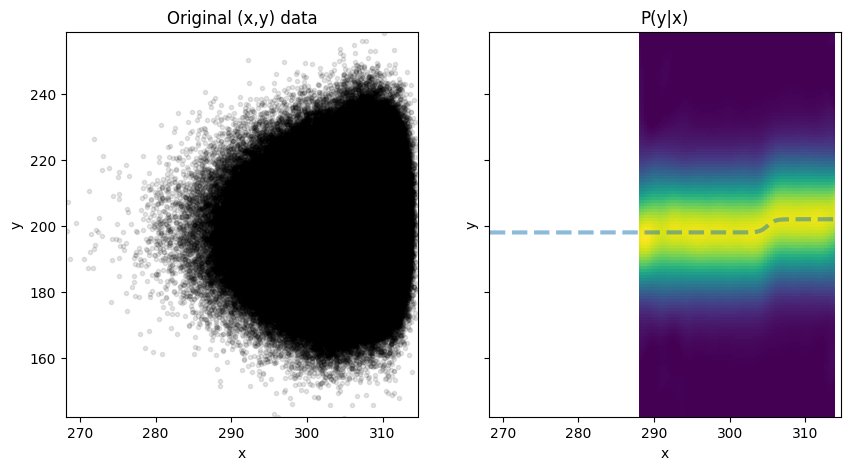

In [5]:
""" Plot the conditional. """

#***************************
# Plot the conditional
#***************************
fig,axs = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)

#Plot a scatter plot of the incoming data
axs[0].plot(x,y,'k.',alpha=0.1)
axs[0].set_title('Original (x,y) data')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

#Draw a contour plot of the conditional
cPDF.plot(ax = axs[1], add_colorbar = False)
#Overplot the original underlying relationship
axs[1].plot(cPDF.x,underlyingFunction(cPDF.x),linewidth=3,linestyle='--',alpha=0.5)
axs[1].set_title('P(y|x)')

plt.savefig('conditional_demo.png')
plt.show()

**Caption:** (left) Samples from a synthetic, noisy dataset meant to emulate a step transition in the relationship between $x$ and $y$.  (right) The conditional distribution of $y$ given $x$, showing that the conditional distribution (shading) follows the true relationship (dashed line) of the underlying data.

Note that data from the conditional distribution are missing for the left half of the figure because data are sparse there.  The `fastKDE.conditional()` function only returns values for regions where $\int p(y~|~x)\,dy \approx 1$; the conditional PDF often fails to normalize properly in regions of sparse data.  These sparse data regions are filled with `numpy.masked`.

## KDE at Specific Points

In [6]:
""" Demonstrate using the pdf_at_points function. """""
train_x = 50*np.random.normal(size=100) + 0.1
train_y = 0.01*np.random.normal(size=100) - 300

test_x = 50*np.random.normal(size=100) + 0.1
test_y = 0.01*np.random.normal(size=100) - 300

test_points = list(zip(test_x, test_y))
test_point_pdf_values = fastkde.pdf_at_points(train_x, train_y, list_of_points = test_points)

Note that this method can be significantly slower than calls to `fastkde.pdf()` since it does not benefit from using a fast Fourier transform during the final stage in which the PDF estimate is transformed from spectral space into data space, whereas `fastkde.pdf()` does.